In this example, we plot the phase and Zernike CPSD before integrating them over the spatial frequencies (we consider the perpendicular component of the frequency wrt the wind vector).

The aim is to show that the phase integrand oscillates very quickly around 0 (being 0 on average) in the range of high temporal and spatial frequencies. Therefore, it is important to choose the spatial frequency range with the proper sampling in order not to overestimate the phase CPSD (e.g. good_spat_freqs = np.logspace(-3, 3, 1000)).

This is not as much important for the Zernike CPSD, because the Zernike integrand is not 0 on average in the range of high temporal and spatial frequencies. 

In [24]:
import numpy as np
from apposto.types.guide_source import GuideSource
from apposto.types.aperture import CircularOpticalAperture
from apposto.atmo.von_karman_covariance_calculator import VonKarmanSpatioTemporalCovariance
from apposto.atmo.cn2_profile import Cn2Profile

source1 = GuideSource((0, 0), np.inf)
source2 = GuideSource((50, 30), 100e3)
aperture1 = CircularOpticalAperture(5, [0, 0, 0])
aperture2 = CircularOpticalAperture(5, [0, 0, 0])
cn2 = Cn2Profile.from_r0s(layersR0=[0.16], layersL0=[25], layersAltitude=[10e3],
                                   layersWindSpeed=[10], layersWindDirection=[-20])
temp_freqs = np.linspace(0.05, 250, 5000)
spat_freqs = np.logspace(-3, 3, 1000)

mode_j = 2
mode_k = 5

vk = VonKarmanSpatioTemporalCovariance(source1=source1, source2=source2, aperture1=aperture1, aperture2=aperture2,
                                        cn2_profile=cn2, spat_freqs=spat_freqs)
phaseIntegrand, _ = vk.integrandOfPhaseCPSD(nLayer=0, temp_freq=temp_freqs[4000])
zernikeIntegrand, _ = vk.integrandOfZernikeCPSD(j=mode_j, k=mode_k, nLayer=0, temp_freq=temp_freqs[4000])

Here, we plot the phase and zernike integrand functions.

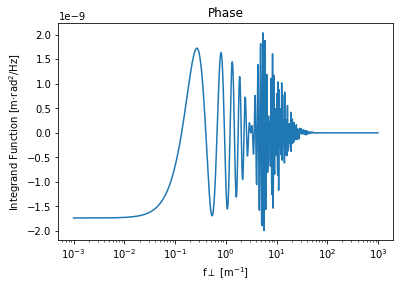

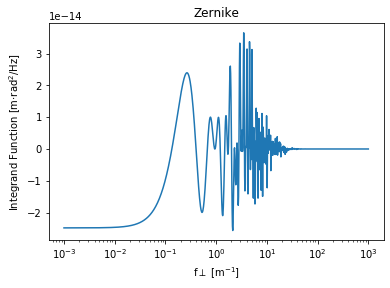

In [34]:
import matplotlib.pyplot as plt

plt.semilogx(spat_freqs2, np.real(phaseIntegrand))
plt.xlabel('f${\perp}$ [m$^{-1}$]')
plt.ylabel('Integrand Function [m$\cdot$rad$^{2}$/Hz]')
plt.title('Phase')
plt.show()

plt.semilogx(spat_freqs, np.real(zernikeIntegrand))
plt.xlabel('f${\perp}$ [m$^{-1}$]')
plt.ylabel('Integrand Function [m$\cdot$rad$^{2}$/Hz]')
plt.title('Zernike')
plt.show()

In [29]:
mode_j = 2
mode_k = 5

phaseCpsd1 = vk.getPhaseCPSD(temp_freqs=temp_freqs)
zernikeCpsd1 = vk.getZernikeCPSD(j=mode_j, k=mode_k, temp_freqs=temp_freqs)

spat_freqs_raw = np.logspace(-3, 3, 100)
vk.setSpatialFrequencies(spat_freqs_raw)
phaseCpsd2 = vk.getPhaseCPSD(temp_freqs)
zernikeCpsd2 = vk.getZernikeCPSD(j=mode_j, k=mode_k, temp_freqs=temp_freqs)

Here, we plot the phase and zernike CPSD. 
We can see that the sampling choice has a larger effect on the phase CPSD.

Text(0.5, 1.0, 'Zernike')

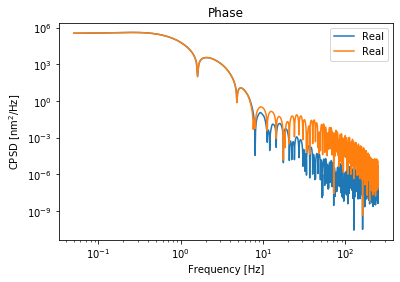

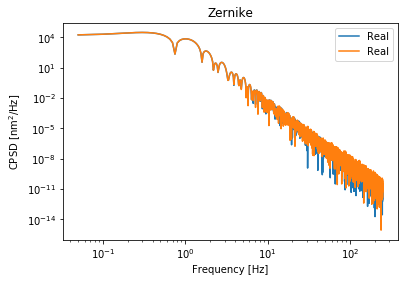

In [33]:
vk.plotCPSD(phaseCpsd1, temp_freqs, 'real', 'log', 5e-7)
vk.plotCPSD(phaseCpsd2, temp_freqs, 'real', 'log', 5e-7)
plt.title('Phase')

plt.figure()
vk.plotCPSD(zernikeCpsd1, temp_freqs, 'real', 'log', 5e-7)
vk.plotCPSD(zernikeCpsd2, temp_freqs, 'real', 'log', 5e-7)
plt.title('Zernike')